# Recurrent Neural Networks

* In this notebook, we perform (univariate) time series forcasting by applying Recurrent Neural Networks (RNN).

* There is a common data analysis task known as time-series prediction, where we have a set of data that show how something varies over time, and we want to predict how the data will vary in the future. 

* It is quite a difficult task, but a fairly important one. 

* It is useful in any field where there is data that appears over time, which is to say almost any field.

* Most notable (if often unsuccessful) uses have been in trying to predict stock markets and disease patterns. 

* The problem is that even if there is some regularity in the time-series, it can appear over many different scales. 

* For example, there is often seasonal variation—if we plotted average temperature over several years, we would notice that it got hotter in the summer and colder in the winter, but we might not notice if there was a overall upward or downward trend to the summer temperatures, because the summer peaks are spread too far apart in the data.

We will use two very distinct data sets. 

* 1. [Ozone data set](https://homepages.ecs.vuw.ac.nz/~marslast/Code/Data/PNoz.dat), i.e., daily measurement of the thickness of the ozone layer above Palmerston North in New Zealand between 1996 and 2004. 

* 2. [S&P 500](https://en.wikipedia.org/wiki/S%26P_500_Index) index set from 2001 - 2019. The S&P 500, or simply the S&P, is a stock market index that measures the stock performance of 500 large companies listed on stock exchanges in the United States. It is one of the most commonly followed equity indices, and many consider it to be one of the best representations of the U.S. stock market. The average annual total return and compound annual growth rate of the index, including dividends, since inception in 1926 has been approximately 9.8%, or 6% after inflation.

Note: more examples for RNN can be found [here](https://www.tensorflow.org/tutorials/structured_data/time_series)

## 1. 'Ozone' data set

There are 4 elements to each vector: 
- the year 
- the day of the year
- the ozone level 
- sulphur dioxide level 
- there are 2855 readings 

You can load the data using PNoz = loadtxt(’PNOz.dat’), which will load the data and stick it into an array called PNoz. To just plot the ozone data so that you can see what it looks like, use plot(arange(shape(PNoz)[0]),PNoz[:,2],’.’).

* Dataset: daily measurement of the thickness of the ozone layer above Palmerston North in New Zealand between 1996 and 2004. 

* Ozone thickness is measured in Dobson Units, which are 0.01 mm thickness at 0 degrees Celsius and 1 atmosphere of pressure. 

* Want to know how the thickness of the ozone layer varies naturally over the year. 

* This should be obvious in the plot shown in the Figure.

* A typical time-series problem is to predict the ozone levels into the future and see if you can detect an overall drop in the mean ozone level.

The following is a reminder of the steps to carry out in the analysis:

- Select inputs and outputs for your problem and consequently the input and output nodes for the network.
- Normalize the data by rescaling. 
- Identify the main parameters to configure, e.g., the network architecture and others.
- Train the network and compare for different parameters
- Assess the performance on the test data.

### Set-up of the notebook

In [1]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pylab as pl
import os
import pandas as pd

Text(0,0.5,'Ozone (Dobson units)')

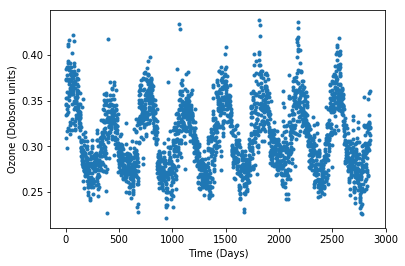

In [2]:
# loading and inspecting the data
PNoz = np.loadtxt('PNoz.dat')
pl.ion()
pl.plot(np.arange(np.shape(PNoz)[0]),PNoz[:,2],'.')
pl.xlabel('Time (Days)')
pl.ylabel('Ozone (Dobson units)')

# inspect the data
#!nl PNoz.dat

As you can see above, an observation is recorded every day. 

Given a specific time, let's say you want to predict the Ozone concentration 1 day in the future. In order to make this prediction, you choose to use XYZ (e.g., 360 or 720) days of observations. Thus, you would create a window containing the last 360 or 720 observations to train the model. Many such configurations are possible, making this dataset a good one to experiment with.

In both the following tutorials, the first 2,000 rows of the data will be the training dataset, and there remaining will be the validation dataset. This amounts to more than 5 years worth of training data.

In [3]:
TRAIN_SPLIT = 100

In [4]:
# Setting seed to ensure reproducibility.
tf.random.set_seed(666)

We will train a model using only a single feature (Ozone concentration), and use it to make predictions for that value in the future.

Let's first extract only the concentration from the dataset.

* Note: It is important to scale features before training a neural network. Standardization is a common way of doing this scaling by subtracting the mean and dividing by the standard deviation of each feature. Alternatively to doing it manually, you could also use a tf.keras.utils.normalize method that rescales the values into a range of [0,1].

In [5]:
# Normalise data
uni_data=PNoz[:,2]
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()
uni_data = (uni_data-uni_train_mean)/uni_train_std


#PNoz[:,2] = PNoz[:,2]-PNoz[:,2].mean()
#PNoz[:,2] = PNoz[:,2]/PNoz[:,2].max()
#uni_data=PNoz[:,2]

### Prepare the training data
The function below returns the above described windows of time for the model to train on. 

Parameters:

 * history_size: the size of the past window of information. 
 * target_size: how far in the future does the model need to learn to predict. 
 * target_size: is the label that needs to be predicted.

In [6]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

Let's now create the data for the univariate model. The model will be given the last 20 recorded Ozone concentration observations, and needs to learn to predict the concentration at the next time step.

In [7]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

This is what the univariate_data function returns.



In [8]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target Ozone concentration to predict')
print (y_train_uni[0])

Single window of past history
[[-0.62226325]
 [-2.05619476]
 [-0.30711346]
 [-1.04771545]
 [-0.58286952]
 [ 0.92591006]
 [ 0.48076099]
 [ 0.45712476]
 [ 0.48470037]
 [-1.02801859]
 [-2.49346508]
 [-1.76468121]
 [-0.31499221]
 [-0.80347437]
 [ 0.68954772]
 [-0.06681175]
 [ 1.00075813]
 [ 0.98106127]
 [ 1.18590863]
 [ 2.00923744]]

 Target Ozone concentration to predict
1.288332310520899


Now that the data has been created, let's take a look at a single example. The information given to the network is given in blue, and it must predict the value at the red cross.



In [9]:
def create_time_steps(length):
  return list(range(-length, 0))

In [10]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from '/usr/lib/python3/dist-packages/matplotlib/pyplot.py'>

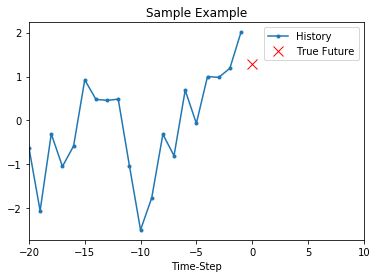

In [11]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')


### Baseline

Before proceeding to train a model, let's first set a simple baseline. Given an input point, the baseline method looks at all the history and predicts the next point to be the average of the last 20 observations.

In [12]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from '/usr/lib/python3/dist-packages/matplotlib/pyplot.py'>

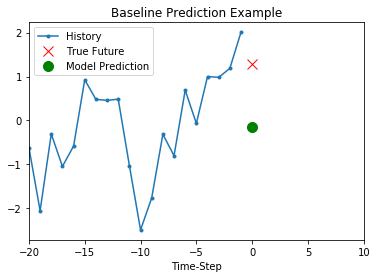

In [13]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

Let's see if you can beat this baseline using a recurrent neural network.

### Recurrent neural network

A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state summarizing the information they've seen so far. For more details, read the [RNN tutorial](https://www.tensorflow.org/tutorials/sequences/recurrent). In this tutorial, you will use a specialized RNN layer called Long Short Term Memory ([LSTM](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/LSTM))

Let's now use `tf.data` to shuffle, batch, and cache the dataset.

In [14]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

The following visualisation should help you understand how the data is represented after batching (figure from [here](https://www.tensorflow.org/tutorials/structured_data/time_series))

![Time Series](time_series.png)

You will see the LSTM requires the input shape of the data it is being given.

In [15]:
# A very small network
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128,input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

# A more complex network
#simple_lstm_model = tf.keras.models.Sequential([
#    tf.keras.layers.LSTM(64,return_sequences=True, input_shape=x_train_uni.shape[-2:]),
#    tf.keras.layers.LSTM(32, return_sequences=True, activation='relu'),    
#    tf.keras.layers.LSTM(16, activation='relu'),
#    tf.keras.layers.Dense(1)
#])

learning_rate = 0.001
simple_lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='mse')

Let's make a sample prediction, to check the output of the model.



In [16]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


Let's train the model now. In the interest of saving time, each epoch will only run for 100 steps, instead of the complete training data as normally done.

In [ ]:
EVALUATION_INTERVAL = 100
EPOCHS = 20

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/20
100/100 [==============================] - 3s 32ms/step - loss: 0.0576 - val_loss: 1.1169
Epoch 2/20
100/100 [==============================] - 3s 34ms/step - loss: 0.0247 - val_loss: 0.9809
Epoch 3/20
100/100 [==============================] - 3s 34ms/step - loss: 0.0021 - val_loss: 0.9898
Epoch 4/20
100/100 [==============================] - 3s 33ms/step - loss: 3.0154e-04 - val_loss: 0.9972
Epoch 5/20
100/100 [==============================] - 3s 33ms/step - loss: 7.2160e-04 - val_loss: 0.9975
Epoch 6/20
100/100 [==============================] - 4s 36ms/step - loss: 9.8123e-06 - val_loss: 0.9995
Epoch 7/20
100/100 [==============================] - 4s 36ms/step - loss: 6.5519e-07 - val_loss: 1.0003
Epoch 8/20
100/100 [==============================] - 4s 35ms/step - loss: 4.9501e-08 - val_loss: 1.0005
Epoch 9/20
 77/100 [======================>.......] - ETA: 0s - loss: 0.0240

Predict using the simple LSTM model
Now that you have trained your simple LSTM, let's try and make a few predictions.

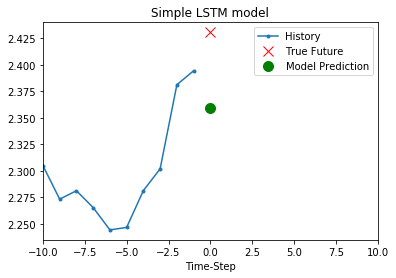

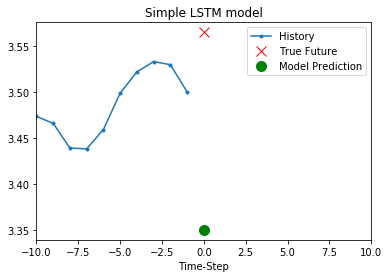

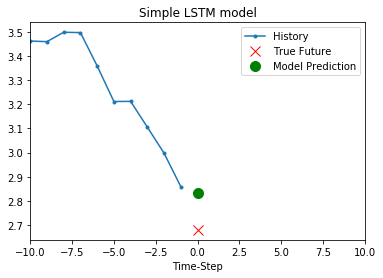

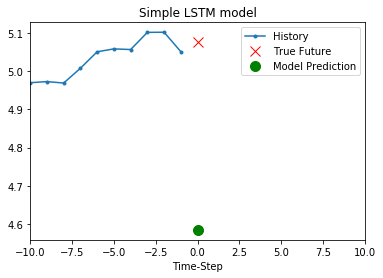

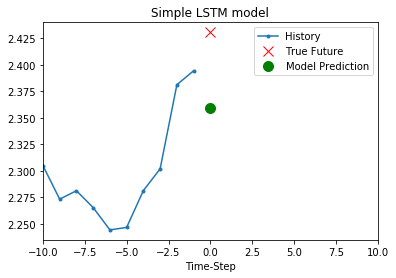

In [672]:
steps = 0
for x, y in val_univariate.take(5):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], steps, 'Simple LSTM model')
  plot.show()

This looks better than the baseline. Now that you have seen the basics, let's move on to part two, where you will work with a S&P500 time series.

## 2. S & P 500 data set

There are XY elements to each vector: 
- SecID
- date	
- ticker	
- low	
- high	
- open	
- close	
- volume

The file is called sp_und.csv


In [601]:
#!ls
df = pd.read_csv("sp_und.csv")

Let's look at the data

In [602]:
df.head()

,secid,date,ticker,low,high,open,close,volume
0,108105,20010102,SPX,1276.05,1320.28,1320.28,1283.27,0
1,108105,20010103,SPX,1274.62,1347.76,1283.27,1347.56,0
2,108105,20010104,SPX,1329.14,1350.24,1347.56,1333.34,0
3,108105,20010105,SPX,1294.95,1334.77,1333.34,1298.35,0
4,108105,20010108,SPX,1276.29,1298.35,1298.35,1295.86,0


In [603]:
df.size
!nl sp_und.csv

     1	secid,date,ticker,low,high,open,close,volume
     2	108105,20010102,SPX,1276.05,1320.28,1320.28,1283.27,0
     3	108105,20010103,SPX,1274.62,1347.76,1283.27,1347.56,0
     4	108105,20010104,SPX,1329.14,1350.24,1347.56,1333.34,0
     5	108105,20010105,SPX,1294.95,1334.77,1333.34,1298.35,0
     6	108105,20010108,SPX,1276.29,1298.35,1298.35,1295.86,0
     7	108105,20010109,SPX,1295.14,1311.72,1295.86,1300.8,0
     8	108105,20010110,SPX,1287.28,1313.76,1300.8,1313.27,0
     9	108105,20010111,SPX,1309.72,1332.19,1313.27,1326.82,0
    10	108105,20010112,SPX,1311.59,1333.21,1326.82,1318.32,0
    11	108105,20010116,SPX,1313.33,1327.81,1318.32,1326.65,0
    12	108105,20010117,SPX,1325.41,1346.92,1326.65,1329.47,0
    13	108105,20010118,SPX,1327.41,1352.71,1329.89,1347.97,0
    14	108105,20010119,SPX,1336.74,1354.55,1347.97,1342.54,0
    15	108105,20010122,SPX,1333.84,1353.62,1342.54,1342.9,0
    16	108105,20010123,SPX,1339.63,1362.9,1342.9,1360.4,0
    17	108105,20010124,SPX,1357.28,1369

  4417	108105,20180723,SPX,2795.14,2808.61,2799.17,2806.98,0
  4418	108105,20180724,SPX,2811.12,2829.99,2820.68,2820.4,0
  4419	108105,20180725,SPX,2817.73,2848.03,2817.73,2846.07,0
  4420	108105,20180726,SPX,2835.26,2845.57,2835.49,2837.44,0
  4421	108105,20180727,SPX,2808.34,2843.17,2842.35,2818.82,0
  4422	108105,20180730,SPX,2798.11,2821.74,2819,2802.6,0
  4423	108105,20180731,SPX,2808.06,2824.46,2809.73,2816.29,0
  4424	108105,20180801,SPX,2805.85,2825.83,2821.17,2813.36,0
  4425	108105,20180802,SPX,2796.34,2829.91,2800.48,2827.22,0
  4426	108105,20180803,SPX,2827.37,2840.38,2829.62,2840.35,0
  4427	108105,20180806,SPX,2835.98,2853.29,2840.29,2850.4,0
  4428	108105,20180807,SPX,2855.92,2863.43,2855.92,2858.45,0
  4429	108105,20180808,SPX,2853.09,2862.44,2856.79,2857.7,0
  4430	108105,20180809,SPX,2851.98,2862.48,2857.19,2853.58,0
  4431	108105,20180810,SPX,2825.81,2842.2,2839.64,2833.28,0
  4432	108105,20180813,SPX,2819.88,2843.4,2835.46,2821.93,0
  4433	108105,20180814,SPX,2826.5

As you can see above, an observation is recorded every day. 

Given a specific time, let's say you want to predict the open price 1 or 2 days in the future. In order to make this prediction, you choose to use 200 days of observations. Thus, you would create a window containing the last 200 observations to train the model. Many such configurations are possible, making this dataset a good one to experiment with.

The function below returns the above described windows of time for the model to train on. The parameter history_size is the size of the past window of information. The target_size is how far in the future does the model need to learn to predict. The target_size is the label that needs to be predicted.

The first 4,000 rows of the data will be the training dataset, and there remaining will be the validation dataset. This amounts to more than 15 years worth of training data.

In [604]:
TRAIN_SPLIT = 4000


Setting the seed again to ensure reproducibility.

In [605]:
tf.random.set_seed(42)

First, you will train a model using only a single feature (close price), and use it to make predictions for that value in the future.

Let's first extract only the close price from the dataset.

In [606]:
uni_data = df['close']
uni_data.index = df['date']
uni_data.head()

date
20010102    1283.27
20010103    1347.56
20010104    1333.34
20010105    1298.35
20010108    1295.86
Name: close, dtype: float64

Let's observe again how this data looks across time.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0bec493c88>],
      dtype=object)

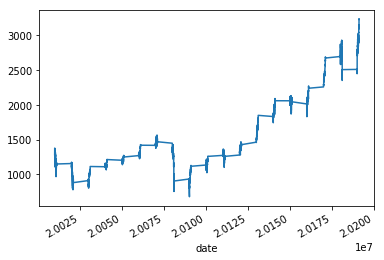

In [607]:
uni_data.plot(subplots=True)

In [608]:
uni_data = uni_data.values

In [609]:
# Let's standardize the data.
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()
uni_data = (uni_data-uni_train_mean)/uni_train_std

Let's create again the data for the univariate model. For part 1, the model will be given the last 10 recorded temperature observations, and needs to learn to predict the temperature at the next time step.



In [610]:
univariate_past_history = 10
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

This is what the univariate_data function returns.

In [611]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target prices to predict')
print (y_train_uni[0])

Single window of past history
[[-0.22954734]
 [-0.0543579 ]
 [-0.09310722]
 [-0.18845453]
 [-0.19523975]
 [-0.18177831]
 [-0.14779772]
 [-0.11087414]
 [-0.13403653]
 [-0.11133739]]

 Target prices to predict
-0.10365292281278325


Now that the data has been created, let's again take a look at a single example. The information given to the network is given in blue, and it must predict the value at the red cross.

<module 'matplotlib.pyplot' from '/usr/lib/python3/dist-packages/matplotlib/pyplot.py'>

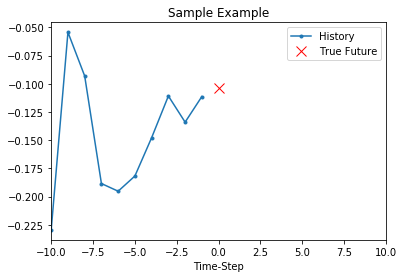

In [612]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

Before proceeding to train a model, let's first set a simple baseline. Given an input point, the baseline method looks at all the history and predicts the next point to be the average of the last 10 observations.

<module 'matplotlib.pyplot' from '/usr/lib/python3/dist-packages/matplotlib/pyplot.py'>

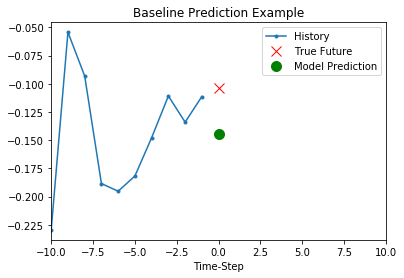

In [613]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

Let's again use tf.data to shuffle, batch, and cache the dataset.

In [614]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

You see here again that the LSTM requires the input shape of the data it is being given.

In [616]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

#learning_rate = 0.01
#simple_lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='mae')


# A more complex network
#simple_lstm_model = tf.keras.models.Sequential([
#    tf.keras.layers.LSTM(64,return_sequences=True, input_shape=x_train_uni.shape[-2:]),
#    tf.keras.layers.LSTM(32, return_sequences=True, activation='relu'),    
#    tf.keras.layers.LSTM(16, activation='relu'),
#    tf.keras.layers.Dense(1)
#])

learning_rate = 0.001
simple_lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='mse')


Let's make a sample prediction, to check the output of the model.

In [617]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


Let's train the model now. 

In [618]:
EVALUATION_INTERVAL = 500
EPOCHS = 4

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/4
500/500 [==============================] - 17s 33ms/step - loss: 0.0143 - val_loss: 0.2255
Epoch 2/4
500/500 [==============================] - 28s 55ms/step - loss: 0.0034 - val_loss: 0.0855
Epoch 3/4
500/500 [==============================] - 18s 35ms/step - loss: 0.0027 - val_loss: 0.0518
Epoch 4/4
500/500 [==============================] - 16s 32ms/step - loss: 0.0021 - val_loss: 0.0500


Predict using the simple LSTM model
Now that you have trained your simple LSTM, let's try and make a few predictions.

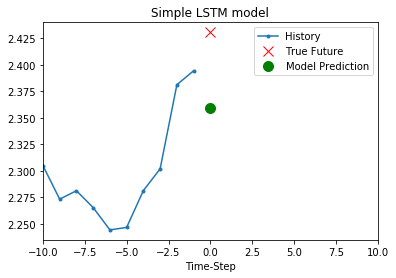

In [622]:
for x, y in val_univariate.take(1):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

### Forecast a multivariate time series

The original dataset contains multiple features. For simplicity, this section considers only four of the original ones. 


In [624]:
df2 = pd.read_csv("sp_und.csv")
df2.head()

,secid,date,ticker,low,high,open,close,volume
0,108105,20010102,SPX,1276.05,1320.28,1320.28,1283.27,0
1,108105,20010103,SPX,1274.62,1347.76,1283.27,1347.56,0
2,108105,20010104,SPX,1329.14,1350.24,1347.56,1333.34,0
3,108105,20010105,SPX,1294.95,1334.77,1333.34,1298.35,0
4,108105,20010108,SPX,1276.29,1298.35,1298.35,1295.86,0


In [625]:
features_considered = ['low', 'high', 'open','close']

features = df2[features_considered]
features.index = df2['date']
features.head()

,low,high,open,close
date,,,,
20010102,1276.05,1320.28,1320.28,1283.27
20010103,1274.62,1347.76,1283.27,1347.56
20010104,1329.14,1350.24,1347.56,1333.34
20010105,1294.95,1334.77,1333.34,1298.35
20010108,1276.29,1298.35,1298.35,1295.86


In [623]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0c0d401780>,
      dtype=object)

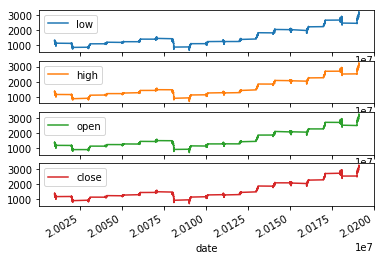

In [626]:
features.plot(subplots=True)

As mentioned, the first step will be to standardize the dataset using the mean and standard deviation of the training data.



In [627]:
# Standardize data set
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

### Single step model
In a single step setup, the model learns to predict a single point in the future based on some history provided.

The below function performs the same windowing task as above, however, here it samples the past observation based on the step size given.

In [628]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

Here, the network is shown data from the last 120 days. 

In [646]:
past_history = 120
future_target = 10
STEP = 1

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [647]:
# Let's look at a single data-point.
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (120, 4)


In [648]:
# prepare data
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [649]:
# set-up the network
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(128,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

learning_rate = 0.001
single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate), loss='mse')

Let's check out a sample prediction.



In [650]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

(256, 1)


In [652]:
EVALUATION_INTERVAL = 120

single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=10)

Epoch 1/4
120/120 [==============================] - 45s 377ms/step - loss: 0.0184 - val_loss: 0.7695
Epoch 2/4
120/120 [==============================] - 38s 315ms/step - loss: 0.0143 - val_loss: 0.7210
Epoch 3/4
120/120 [==============================] - 56s 466ms/step - loss: 0.0127 - val_loss: 0.6402
Epoch 4/4
120/120 [==============================] - 51s 429ms/step - loss: 0.0122 - val_loss: 0.2858


In [641]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

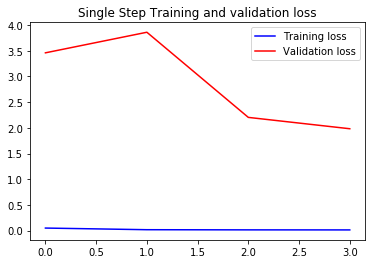

In [642]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

#### Predict a single step future
Now that the model is trained, let's make a few sample predictions. The model is given the history of four features over the past 120 days. The prediction is made one day into the future (hence the gap between the history and prediction).

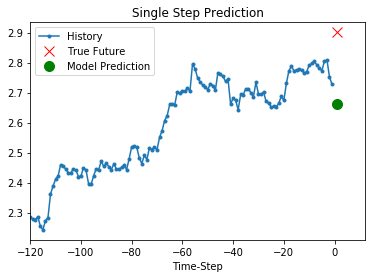

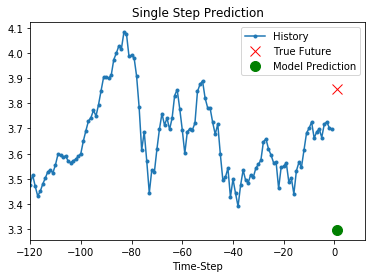

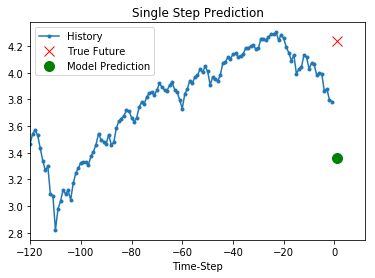

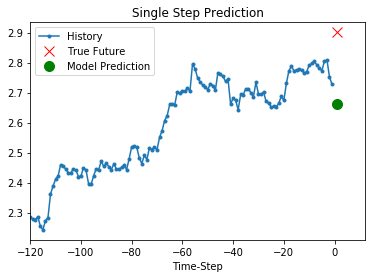

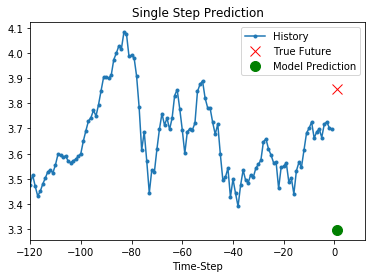

In [658]:
step=1
for x, y in val_data_single.take(5):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], step,
                   'Single Step Prediction')
  plot.show()

#### Multi-Step model
In a multi-step prediction model, given a past history, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predict a sequence of the future.

For the multi-step model, the training data again consists of recordings over the past 120 days. However, here, the model needs to learn to predict the price for the next 12 days. 

In [659]:
future_target = 12
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

Now, we check out a sample data-point.

In [660]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (120, 4)

 Target temperature to predict : (12,)


In [661]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

Plotting a sample data-point.

In [662]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

In this plot and subsequent similar plots, the history and the future data are sampled every hour.

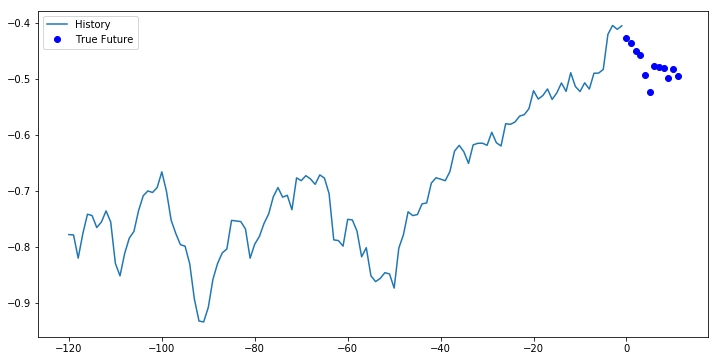

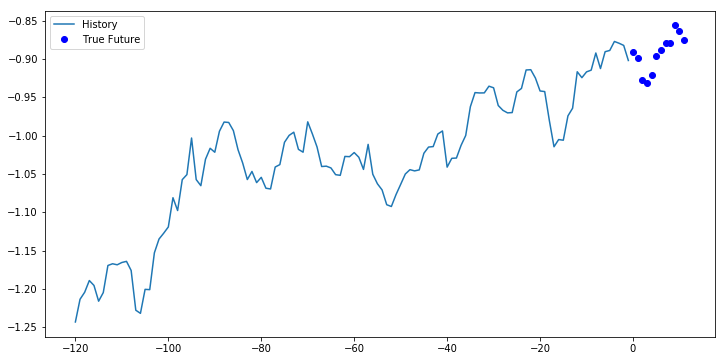

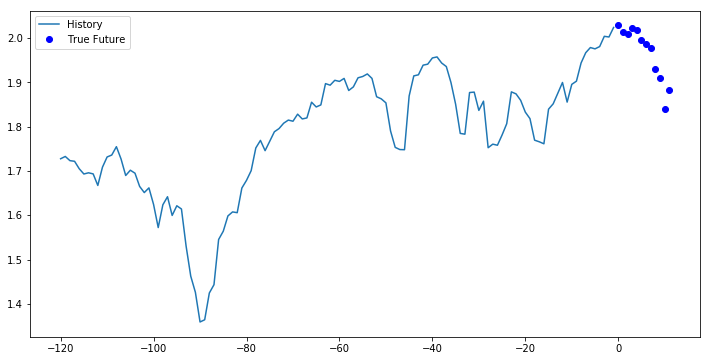

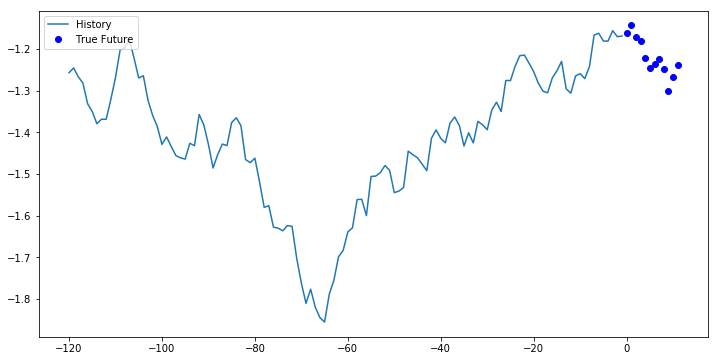

In [670]:
for x, y in train_data_multi.take(4):
  multi_step_plot(x[0], y[0], np.array([0]))

Since the task here is a bit more complicated than the previous task, the model now consists of two LSTM layers. Finally, since 12 predictions are made, the dense layer outputs 12 predictions.

In [664]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(12))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

Let's see how the model predicts before it trains.



In [665]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

(256, 12)


In [666]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/4
120/120 [==============================] - 24s 203ms/step - loss: 46078.5117 - val_loss: 2.2563
Epoch 2/4
120/120 [==============================] - 16s 134ms/step - loss: 0.2596 - val_loss: 1.6892
Epoch 3/4
120/120 [==============================] - 16s 134ms/step - loss: 0.1447 - val_loss: 2.3666
Epoch 4/4
120/120 [==============================] - 16s 134ms/step - loss: 0.0916 - val_loss: 1.4797


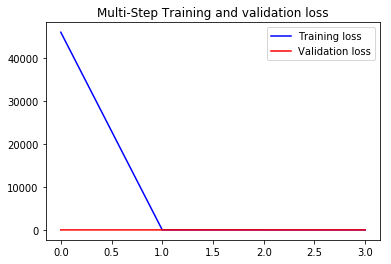

In [667]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')


#### Predict a multi-step future
Let's now have a look at how well your network has learnt to predict the future.



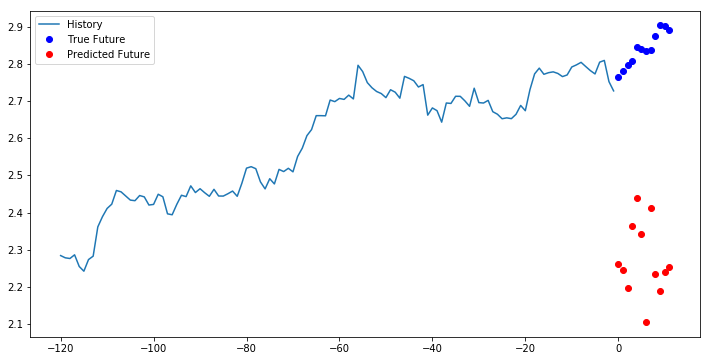

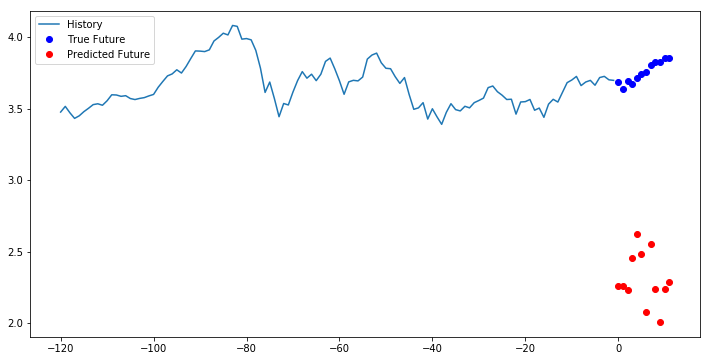

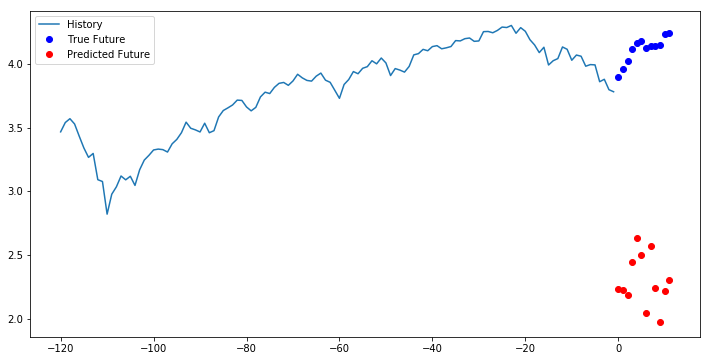

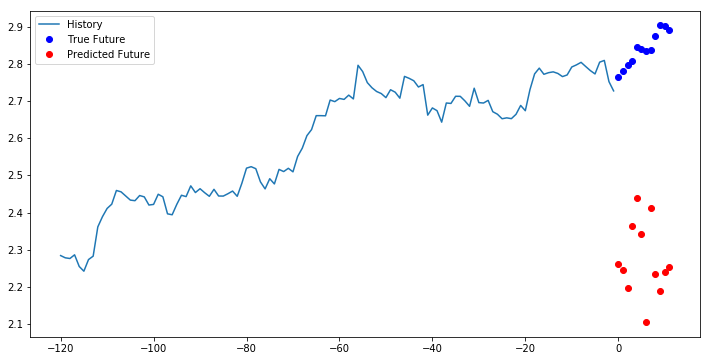

In [669]:
for x, y in val_data_multi.take(4):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])